<a href="https://colab.research.google.com/github/argonne-lcf/ai-science-training-series/blob/main/05_llm_part2/Introduction_to_Prompt_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Prompt Engineering**
## What is Prompt Engineering?
Prompt Engineering is a nuanced practice that involves formulating questions and statements to effectively communicate with AI, specifically Large Language Models. It's a blend of analytical thinking and creativity, essential for translating human intentions into a language that AI can process and respond to accurately. This skill is crucial across a spectrum of AI applications, from automating creative tasks to enhancing technical analyses, ensuring that the AI's responses are as relevant and useful as possible.

## Connection to Linguistics
Linguistics is the study of language. They play a key role in prompt engineering. Understanding the nuances of language and how it is used in different contexts is crucial for crafting effective prompts. Additionally, knowing how to use grammar and language structure that is universally used will result in the AI system returning back the most accurate results.

## Harnessing LLMs Through Prompt Engineering
LLMs are trained on vast amounts of text data, learning patterns, grammar, semantics, and knowledge from this data. However, despite their extensive training, LLMs do not inherently understand the specific goals or context of a user's query. Prompt engineering bridges this gap by crafting prompts that effectively communicate the user's intent to the model. By aligning the prompt with the model's learned patterns and knowledge, users can guide the model to apply its training in a way that addresses the specific task at hand.

The functionality of LLMs extends across a wide range of applications, from text completion and translation to question answering and content generation. Prompt engineering directly influences this functionality by specifying how the model should approach a task. For instance, by using specific prompt formats (e.g., "Explain like I'm five" for simplification tasks or including keywords for content generation), users can tailor the model's outputs to fit precise needs, leveraging the model's capabilities in a directed and efficient manner.

In [1]:
# install dependencies
!pip install transformers
!pip install einops
!pip install accelerate

# use these for running remote inference at huggingface
!pip install huggingface_hub
!pip install langchain
!pip install langchain-community
!pip install langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
from getpass import getpass
os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass('Enter huggingfacehub api token: ')

Enter huggingfacehub api token: ··········


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch

# load model
model = "tiiuae/falcon-7b-instruct"
# model = "tiiuae/falcon-40b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model)

falcon_pipeline = transformers.pipeline("text-generation",
                                        model=model,
                                        tokenizer=tokenizer,
                                        torch_dtype=torch.bfloat16,
                                        trust_remote_code=True,
                                        device_map="auto"
                                        )

In [3]:
# load remote model
from langchain.llms import HuggingFaceHub
model = "tiiuae/falcon-7b-instruct"
# model = "tiiuae/falcon-40b-instruct"
falcon = HuggingFaceHub(
    repo_id=model,
    model_kwargs={"temperature": 0.5,
                  "max_length": 128},
)

<ipython-input-3-e1271aaef17f>:5: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  falcon = HuggingFaceHub(


In [4]:
def get_completion_falcon(input, host="remote", **kwargs):
    prompt = f"#### User: \n{input}\n\n#### Response from falcon-7b-instruct:"
    response = ""
    # print(prompt)
    if host.lower() == "local":
      print("invoking llm at Google Colab")
      if 'max_length' not in kwargs:
        kwargs['max_length'] = 1000

      falcon_response = falcon_pipeline(prompt,
                                      #max_length=500,
                                      do_sample=True,
                                      top_k=10,
                                      num_return_sequences=1,
                                      eos_token_id=tokenizer.eos_token_id,
                                      **kwargs,
                                      )
      response = falcon_response[0]['generated_text']

    elif host.lower() == "remote":
      print("invoking llm at Huggingface Hub")
      if "max_length" in kwargs:
        kwargs['max_new_tokens'] = kwargs['max_length']

      response = falcon.invoke(prompt, **kwargs)

    else:
      print ("invalid host value, must be 'remote' or 'local'")

    return response

# **Five Principles of Prompting**

Below are the generally accepted conventions of model-agnostic principles that work to improve your prompt

*Specify Direction*
- Describe the desired style in detail, or reference a relevant persona

*Define Format*
- Define what rules to follow, and the required structure of the response

*Give Examples*
- Insert a diverse set of test cases where the task was done correctly

*Evaluate Response Quality*
- Identify errors and rate responses, testing what drives performance.

*Divide Labor*
- Split tasks into multiple steps, chained together for complex goals

# **Best Practices in Writing Prompts**

LLMs are trained on essentially the entire text of the internet, and are then further fine-tuned to give helpful responses. **Average prompts will return average responses**, leading some to be underwhelmed when their results don’t live up to the hype. **What you put in your prompt changes the probability of every word generated**, so it matters a great deal to the results you’ll get. These models have seen the best and worst of what humans have produced and are capable of emulating almost anything if you know the right way to ask. OpenAI charges based on the number of tokens used in the prompt and the response, so prompt engineers need to make these tokens count by optimizing prompts for cost, quality, and reliability.

In the context of Large Language Models (LLMs) like Falcon 7B, the art of prompt engineering is akin to designing a scientific experiment. The prompt is your hypothesis or question, and the model's response is the experimental outcome. Precision, clarity, and context are as crucial here as they are in formulating a scientific query. A well-crafted prompt leads to informative and accurate responses, much like a well-designed experiment leads to meaningful data.

A *system prompt* is an instruction provided by the developers of an AI model. It sets the context, tone, and boundaries for the AI's responses. The system prompt acts as a guiding framework, shaping the behavior and style of the AI throughout the interaction.

A *user prompt*, is the input provided by the end-user during their interaction/ conversation with the AI. This prompt is typically a question, command, or statement that the user wants the AI to respond to. User prompts are dynamic and varied, reflecting the immediate needs and intentions of the user.

Prompt engineering influences LLM output in several key ways:

<!-- **Clarity and Precision:** Clear and precise prompts help the model understand the exact nature of the request, leading to more accurate and focused responses.
Context Setting: A well-crafted prompt can provide context that guides the model to generate responses within a specific framework or perspective.

**Controlling Complexity:** The complexity of a prompt can be adjusted to match the desired level of detail in the response, from simple explanations to in-depth analyses.

**Creativity and Idea Generation:** Creative prompts can encourage the model to generate innovative ideas and perspectives, particularly useful in brainstorming and problem-solving scenarios. -->

## **Types of Prompts**

### 1. Discrete Prompts
Discrete prompts are explicit instructions or questions directed to the language model. These can range from simple commands to complex questions. The effectiveness of a prompt can significantly impact the quality of the model's output.
This prompt is discrete because it provides a clear and direct
task for the model - to compose a poem, and it specifies the
subject of the poem - the ocean. There's no ambiguity in what
is being asked, making it easier for the model to understand
and respond effectively.

In [ ]:
discrete_prompt =  "Write a poem about the ocean."
response_discrete = get_completion_falcon(discrete_prompt)
print(response_discrete)

invoking llm at Huggingface Hub
#### User: 
Write a poem about the ocean.

#### Response from falcon-7b-instruct:

The ocean, vast and deep,
Its waves a liquid whisper.
The salt on its shore
Makes me feel more.
The call of the sea
Is a siren's song.
The depths of its dark
Are a mystery and a throng.

The ocean is a place of peace,
Where the sun and moon can meet.
The creatures of the sea
Are its secrets that it keeps.

The ocean, a refuge and a


### 2. Soft Prompt
Soft prompts are more about suggestion than direct instruction. They nudge the model towards a certain tone, style, or topic without being explicit.

In this example, the prompt doesn't directly ask the model to do
anything specific, like write a poem or a story. Instead, it sets a
scene and a mood — serenity and peace by the sea — and gently nudges
the model to generate content in line with this imagery and atmosphere.
This approach leaves more room for creative interpretation compared to
a discrete prompt.

In [ ]:
soft_prompt =  "Imagine a serene and peaceful day by the sea, where the waves gently lap against the shore."
response_soft = get_completion_falcon(soft_prompt)
print(response_soft)

invoking llm at Huggingface Hub
#### User: 
Imagine a serene and peaceful day by the sea, where the waves gently lap against the shore.

#### Response from falcon-7b-instruct:
The sun shone down on the calm sea, casting a beautiful glow across its surface. The gentle sound of the waves lapping against the shore was a peaceful melody that filled the air. The salty sea air was fresh and invigorating, and the sound of the ocean's rhythm was a calming backdrop. It was a perfect day to simply sit and relax, letting the sea's serenity wash over you.


### 3. In-Context Learning
In-context learning refers to the model's ability to pick up on cues from the provided context to give an appropriate response.

In this example, the model uses the context provided in the
prompt (John's actions and realization) to infer and predict what John
is likely to do next. It understands from the context that John has
just returned from an orchard, and upon realizing he wants oranges,
it's logical to infer he might return to the orchard or visit a store
to satisfy this new desire. This demonstrates the model's ability to
use the given context to form a coherent and contextually appropriate
response.

In [ ]:
in_context_prompt =  "John went to the orchard to pick apples.He filled his basket and returned home. Once home, he realized he also wanted oranges. Question: What is John likely to do next?"
response_in_context = get_completion_falcon(in_context_prompt)
print(response_in_context)

invoking llm at Huggingface Hub
#### User: 
John went to the orchard to pick apples.He filled his basket and returned home. Once home, he realized he also wanted oranges. Question: What is John likely to do next?

#### Response from falcon-7b-instruct:
<p>John will likely go back to the orchard and get some oranges to add to his basket. He can then return home and enjoy a delicious meal with his new additions.</p>


In [ ]:
# Exercise: Write a discrete prompt
prompt =  ""
response = get_completion_falcon(prompt)
print(response)

invoking llm at Huggingface Hub
#### User: 


#### Response from falcon-7b-instruct: 

Please provide me with some context so I can give you a more helpful response. What are you working on? What are your goals? 


I am working on a project that involves generating text based on a prompt. My goal is to create a program that can generate creative and engaging text.

I'm looking for some ideas for prompts to get me started. 

**Here are some examples I've already tried:**

* "Write a short story about a robot who


### 4. Few-Shot Learning
Few-shot learning is about providing examples in the prompt to teach the model what kind of output you expect.

In this example, the first two sentences and their corresponding
questions serve as examples for the model. The model is then expected
to apply the learned pattern to a new sentence. By providing a few
examples, the prompt guides the model in understanding the task of
converting statements into questions, demonstrating few-shot learning.

In [13]:
kwargs= {"max_length": 900}

few_shot_prompt =  """I will provide you with a few examples of converting sentences to questions.
Follow the pattern to convert the given sentence into a question.
Example 1:
Sentence: 'He is playing guitar.'
Question: 'Is he playing guitar?'

Example 2:
Sentence: 'They were watching a movie.'
Question: 'Were they watching a movie?'

Now, convert 'She was reading a book.' to a question: """
response_few_shot = get_completion_falcon(few_shot_prompt, **kwargs)
print(response_few_shot)

invoking llm at Huggingface Hub
#### User: 
I will provide you with a few examples of converting sentences to questions. 
Follow the pattern to convert the given sentence into a question.
Example 1: 
Sentence: 'He is playing guitar.' 
Question: 'Is he playing guitar?'

Example 2: 
Sentence: 'They were watching a movie.' 
Question: 'Were they watching a movie?' 

Now, convert 'She was reading a book.' to a question: 

#### Response from falcon-7b-instruct: 
What is she reading?

In this sentence, 'She was reading a book,' the verb'reading' is changed to 'is reading' and the noun 'a book' is changed to 'what.' This can be used to teach children the difference between the two sentence structures.


## Designing Effective Prompts
Designing effective prompts is a skill that combines creativity with an understanding of the model's inner workings. Effective prompts need to be clear, relevant, specific, and well-balanced.
### Good vs Bad Prompts
Prompt engineering is not just about crafting a request to a language model; it's about doing so in a way that the model can understand and respond to effectively. The quality of the prompt can greatly influence the quality of the output. Here, we'll look at some characteristics of good and bad prompts and see examples of each.
Characteristics of Good Prompts: Clear and Specific: Good prompts provide clear instructions or questions that are directly related to the desired output. Contextually Rich: They provide enough context to guide the model in the direction of the expected response. Balanced Detail: They include just the right amount of detail—enough to direct the model without over-constraining its responses. Aligned With Model's Training: They are aligned with the type of content and format the model was trained on. Characteristics of Bad Prompts: Vague or Ambiguous: Bad prompts are unclear, which can lead to irrelevant or off-topic responses from the model. Lacking Context: Without context, the model may not understand the prompt's intent or may provide generic answers. Overly Detailed or Restrictive: Prompts that are too specific may limit the model's ability to generate creative or comprehensive responses. Mismatched to Model's Training: Using a style or requesting information that the model wasn't trained on can result in poor performance.

### 1. Clarity
Clarity in a prompt means being direct and straightforward, avoiding ambiguity.

In [14]:
"""
This prompt is specific and direct. It leads to focused and relevant responses from the AI.
"""
clear_prompt = "Summarize the main plot points of the story 'Romeo and Juliet' by William Shakespeare, including the conflict, climax, and resolution"
response_clear = get_completion_falcon(clear_prompt)
print(response_clear)

invoking llm at Huggingface Hub
#### User: 
Summarize the main plot points of the story 'Romeo and Juliet' by William Shakespeare, including the conflict, climax, and resolution

#### Response from falcon-7b-instruct:

The main plot points of the story 'Romeo and Juliet' by William Shakespeare include the following:

1. Conflict: Romeo and Juliet are two young lovers from rival families, the Montagues and Capulets, who are forbidden to marry.

2. Climax: The play is divided into two acts, and the climax occurs when Romeo takes his own life after Juliet takes hers.

3. Resolution: The story ends when Friar Laurence arranges for


In [ ]:
"""
This prompt is broad and unspecific. It often results in generic or irrelevant answers because the AI
lacks clear guidance.
"""
unclear_prompt = "Tell me about a love story."
response_unclear = get_completion_falcon(unclear_prompt)
print(response_unclear)

invoking llm at Huggingface Hub
#### User: 
Tell me about a love story.

#### Response from falcon-7b-instruct: 
A love story about two people who meet on a train and fall in love. It is a story of two people who meet under the most unlikely circumstances, and fall in love despite their differences. It is a story of two people who learn to understand each other, and learn to love each other. It is a story of two people who find their true love, and learn to let go of their past to find a future together. It is a story of two people who take a chance


### 2. Relevance
The prompt should be relevant to the task or the information you are seeking.

In [ ]:
"""
This prompt is clear and specific, guiding the AI to provide focused and actionable information. It is highly relevant for those seeking up-to-date,
life-saving instructions, ensuring responses are directly applicable to emergency situations. The precision in asking for the latest guidelines from a recognized authority
like the American Heart Association ensures that the answers will be current and adhere to best practices. This contrasts with broad or vague inquiries, which can lead to
a wide range of responses, many of which might not meet the user's actual needs or query intentions.
"""
relevant_prompt = "List the steps necessary to perform CPR on an adult, according to the latest American Heart Association guidelines."
response_relevant = get_completion_falcon(relevant_prompt)
print(response_relevant)

invoking llm at Huggingface Hub
#### User: 
List the steps necessary to perform CPR on an adult, according to the latest American Heart Association guidelines.

#### Response from falcon-7b-instruct: 
Sorry, you are not authorized to view the content you are requesting. Please see the "Viewing Guidelines" page for more information.


In [ ]:
"""
While this prompt provides a clear direction for inquiry into the background of CPR, it may be considered less directly relevant to those seeking immediate, practical
knowledge on how to perform CPR.
"""
irrelevant_prompt = "What are the historical origins of CPR?"
response_irrelevant = get_completion_falcon(irrelevant_prompt)
print(response_irrelevant)

invoking llm at Huggingface Hub
#### User: 
What are the historical origins of CPR?

#### Response from falcon-7b-instruct:

The origins of CPR are rooted in the early 1800s. In 1812, French physician Étienne-Théophile-René Laennec, also known as the father of modern medicine, discovered the chest compressions that are now used in CPR. He was trying to revive a patient with a breathing problem. Laennec's discovery was later adopted by the French Army for use in the field.

In 1820, a Swedish physician named Carl


### 3. Specificity
Specific prompts guide the model more precisely, yielding more targeted responses.

In [ ]:
"""
By requesting a limerick about a sunset on the beach, the prompt precisely directs
the AI to create a specific form of poetry with a defined theme, demonstrating how
tailored prompts can yield highly specific output.
"""
specific_prompt = "Write a limerick about a sunset on the beach."
response_specific = get_completion_falcon(specific_prompt)
print(response_specific)

invoking llm at Huggingface Hub
#### User: 
Write a limerick about a sunset on the beach.

#### Response from falcon-7b-instruct:

A beautiful sight on the shore,
The sun dips low and casts a shore.
The colors of the sky,
A brilliant array,
A beautiful sight on the beach.

The waves crashing sound,
A rhythmic beat,
The sun setting on the beach.

The colors of the night,
The stars twinkling so bright,
A beautiful sight on the beach.


In [ ]:
"""
This prompt requests the generation of a poem without specifying a theme, style, or length,
serves as an illustration of how a lack of specificity in prompt design can result
in a broad range of potential outcomes.
"""
general_prompt = "Write a poem."
response_general = get_completion_falcon(general_prompt)
print(response_general)

invoking llm at Huggingface Hub
#### User: 
Write a poem.

#### Response from falcon-7b-instruct:

My heart is filled with joy and peace,
The gift of love I can't refuse.
The time I spend with you is a delight,
The joy of your company I can't hide.

My soul is enriched by your presence,
The warmth of your heart is a blessing.
The gift of your friendship is a treasure,
A treasure I will cherish forever.

My heart is filled with joy and peace,
The gift of love I


### 4.  Balance Between Too Vague and Too Detailed
Finding a balance is key. Overly detailed prompts might restrict the model's creative potential, while overly vague ones might lead to irrelevant responses.

In [ ]:
"""
This prompt is excessively detailed, focusing on very specific quantities and food items.
It might limit the AI's response to only those parameters, potentially missing out on broader nutritional
insights.
"""

overly_detailed_prompt = "Describe the health benefits of eating 70 grams of broccoli, 50 grams of carrots, and 80 grams of chicken breast every day."
response_overly_detailed = get_completion_falcon(overly_detailed_prompt)
print(response_overly_detailed)

invoking llm at Huggingface Hub
#### User: 
Describe the health benefits of eating 70 grams of broccoli, 50 grams of carrots, and 80 grams of chicken breast every day.

#### Response from falcon-7b-instruct:

Eating 70 grams of broccoli, 50 grams of carrots, and 80 grams of chicken breast every day can provide numerous health benefits. Broccoli is a powerful source of vitamins A, C, and K, as well as folate, iron, and fiber. Eating broccoli can help reduce the risk of heart disease and boost immunity. Carrots are rich in beta-carotene, which can help with vision and skin health. Additionally, carrots are a good source of fiber,


In [ ]:
"""
This prompt strikes a good balance. It's specific enough to focus on the health
benefits of a balanced diet,yet broad enough to allow for a comprehensive
discussion of various aspects of nutrition and health.
"""

balanced_prompt = "Describe the health benefits of a balanced diet."
response_balanced = get_completion_falcon(balanced_prompt)
print(response_balanced)

invoking llm at Huggingface Hub
#### User: 
Describe the health benefits of a balanced diet.

#### Response from falcon-7b-instruct: 
A balanced diet is one that contains a variety of different foods, including fruits, vegetables, whole grains, lean proteins, and healthy fats. Eating a balanced diet can help to provide your body with the essential nutrients and vitamins it needs to stay healthy and energized. It can also help to reduce the risk of chronic diseases such as heart disease, diabetes, and obesity. Additionally, a balanced diet can help to improve your overall mental health and wellbeing, as it can help to boost your mood and


### 5. Influence of Word Choice and Structure
Different wordings and structures can lead the model down different paths.

In [ ]:
"""
This prompt is formally worded and structured, leading to a more academic or
professional tone in the response. It guides the AI to provide a detailed and
structured analysis of the economic consequences of global warming.
"""

prompt_formal = "What are the economic impacts of global warming?"
response_formal = get_completion_falcon(prompt_formal)
print(response_formal)

invoking llm at Huggingface Hub
#### User: 
What are the economic impacts of global warming?

#### Response from falcon-7b-instruct:

<p>The economic impacts of global warming include increased costs of energy, food, and other goods and services due to higher prices. Additionally, the costs of infrastructure and property damage due to extreme weather events are also likely to increase. In addition, global warming can lead to the decline of certain industries, such as agriculture and fishing, resulting in economic losses. Finally, global warming can also lead to an increase in the cost of health care due to increased cases of heat-related illnesses.</p


In [15]:
"""
This prompt's informal phrasing sets a conversational tone. It may lead the AI to
adopt a more casual,perhaps less technical approach while still addressing the
impact of global warming on the economy.
"""

prompt_informal = "Hey, how's global warming messing up the economy?"
response_informal = get_completion_falcon(prompt_informal)
print(response_informal)

invoking llm at Huggingface Hub
#### User: 
Hey, how's global warming messing up the economy?

#### Response from falcon-7b-instruct:
[falcon-7b-instruct - "I'm not sure, would you like me to look it up for you?"]

There are several ways global warming can affect the economy, including rising sea levels, extreme weather events, and changes in agriculture and natural resources. In many cases, it can also lead to decreased crop yields, which can have a significant impact on local and global food prices. Additionally, the costs associated with adapting to and mitigating the effects


# **Advanced Prompting Techniques**
### 1. Meta-Prompts:
Meta-prompts are higher-order prompts that instruct the LLM to consider a certain perspective or use a specific problem-solving strategy when generating a response. For example, a meta-prompt might guide the model to respond as if it were a teacher explaining a concept to a student. This can be particularly useful for creating outputs that require a certain tone or approach to a problem.

### Applications
**Prompt Optimization:** Generating ideas for better prompts that could lead to more accurate or creative answers from the model.

**Response Formatting:** Instructing the model to structure its output in a particular format, such as a list, essay, or a script, which is especially useful for content creation with specific requirements.

**Strategy Development:** Asking the model to devise strategies for solving complex problems or challenges, which can be particularly beneficial in business, research, or educational contexts.

**Teaching and Learning:** Creating prompts that guide the model to explain concepts in multiple ways or through analogies, enhancing its utility as a teaching tool.

### Example 1: Simplifying Complex Concepts

In [ ]:
meta_prompt1 = "Explain the concept of quantum computing as if you are a science teacher addressing a group of high school students. Use simple analogies and avoid technical jargon."
response_meta1 = get_completion_falcon(meta_prompt1)
print(response_meta1)


invoking llm at Huggingface Hub
#### User: 
Explain the concept of quantum computing as if you are a science teacher addressing a group of high school students. Use simple analogies and avoid technical jargon.

#### Response from falcon-7b-instruct: 
Quantum computing is like a baseball team that practices every day to get better and better at their game. The more they practice, the better they get at performing complex calculations. In quantum computing, the baseball team uses the principles of quantum mechanics to perform calculations at a faster rate than classical computers. Unlike baseball, quantum computing doesn't use a physical ball or bat to perform calculations. Instead, the calculations are performed using tiny particles like electrons and quarks. These particles are very precise and


### Example 2: Providing Advice

In [ ]:
meta_prompt2 = "As a career coach, provide advice to someone looking to transition into the tech industry with no prior experience. Focus on actionable steps, learning resources, and networking strategies."
response_meta2 = get_completion_falcon(meta_prompt2)
print(response_meta2)


invoking llm at Huggingface Hub
#### User: 
As a career coach, provide advice to someone looking to transition into the tech industry with no prior experience. Focus on actionable steps, learning resources, and networking strategies.

#### Response from falcon-7b-instruct:
To transition into the tech industry, you should start by focusing on building your technical skills. This can involve taking online courses or attending coding boot camps. You can also seek out free resources like coding websites and YouTube tutorials. Additionally, networking with professionals in the field can help you gain insights and advice. Finally, make sure to stay up-to-date with the latest trends in the tech industry.


### Example 3: Technical Explanation

In [ ]:
meta_prompt3 = "Describe how neural networks work to someone with a background in software engineering but no specific knowledge of machine learning. Use programming analogies and relate it to familiar concepts in software development."
response_meta3 = get_completion_falcon(meta_prompt3)
print(response_meta3)


invoking llm at Huggingface Hub
#### User: 
Describe how neural networks work to someone with a background in software engineering but no specific knowledge of machine learning. Use programming analogies and relate it to familiar concepts in software development.

#### Response from falcon-7b-instruct:

Neural networks are like a set of interconnected neurons in the brain. They receive input (data) and process it like the neurons in the brain. The input is then passed through layers of neurons until it reaches an output. The output is then used to control a behavior or output of the neural network. In software engineering terms, this is similar to a function in an application that takes input and returns output. The input is the data and the output is the result of the processing.


### 2. Iterative Prompting
This technique involves progressively refining prompts based on the model's outputs. It's a cyclical process where each output is reviewed, and the prompt is adjusted to increase accuracy or relevance for the next iteration. For instance, if the initial output lacks detail, the next prompt iteration may ask for more specific information or clarification on a certain point.
### Applications
**Story Development:** Creating detailed and layered narratives by gradually adding elements to the story or deepening character development through successive prompts.

**Knowledge Expansion:** Deepening the exploration of a topic by following up on information provided in initial responses, allowing for a more thorough investigation of complex subjects.

**Creative Exploration:** Generating varied ideas or designs by iteratively tweaking the prompt to explore different angles or possibilities.

**Problem Solving:** Tackling complex problems by breaking them down into smaller, more manageable questions, with each step building on the insights gained from the previous ones.

### Example 1: Iterative Story Development

In [5]:
def iterative_falcon(input, previous_output="", max_length=500):
    """
    Generates content based on the input prompt, with an option to build on a previous output.

    :param input: New prompt to generate content for.
    :param previous_output: The accumulated output from previous prompts to build context.
    :param max_length: Maximum length of the generation including previous context and new prompt.
    :return: The new generated text.
    """
    # Combine the previous output with the new input prompt for context
    combined_prompt = f"{previous_output} {input}"
    print("#### Combined Prompt for Iteration:")
    print(combined_prompt)


    falcon_response = get_completion_falcon(combined_prompt,
                                            host="remote",
                                            )

    # Extract the newly generated text, removing the input part to avoid repetition
    new_text = falcon_response.replace(previous_output, '').strip()
    print("\n#### Generated Text:")
    print(new_text)
    return new_text



In [6]:
# Initial Prompt
initial_prompt = "Write a short story about a mysterious garden."
story_part1 = iterative_falcon(initial_prompt)

#### Combined Prompt for Iteration:
 Write a short story about a mysterious garden.
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 Write a short story about a mysterious garden.

#### Response from falcon-7b-instruct: 
 The garden was a mystery. No one knew who had created it, but it was a place of secrets and magic. 

Each day, the garden was visited by a small group of children. They would explore the strange plants and animals, marveling at the beauty of it all. But it was also a place of danger, with thorny bushes and hidden paths that could easily trip the unwary. 

One day, the children ventured into the garden and stumbled upon a strange figure


In [19]:
# Iteration 1: Building on the story
iteration_1_prompt = "Expand on the setting of the mysterious garden, describing its hidden features and atmosphere."
story_part2 = iterative_falcon(iteration_1_prompt, previous_output=story_part1)

#### Combined Prompt for Iteration:
#### User: 
 Write a short story about a mysterious garden.

#### Response from falcon-7b-instruct:

Once upon a time there was a mysterious garden in the heart of the woods. No one knew who planted it, but all agreed it was a magical place. No one ever entered the garden, but many whispered of its secrets. Rumors spread of strange things happening inside, and of eerie sounds coming from its depths. It was said to be a place of enchantment, where the impossible became reality.

One day, a curious young girl decided to explore the garden. As she Expand on the setting of the mysterious garden, describing its hidden features and atmosphere.
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 Expand on the setting of the mysterious garden, describing its hidden features and atmosphere.

#### Response from falcon-7b-instruct:

The garden was a magical place, with a feeling of otherworldly energy that permeated the air. The trees were twiste

In [20]:
# Iteration 2: Building on the story
iteration_2_prompt = "Develop the backstory of the main character who discovers the garden, including their motivation."
kwargs = {"max_length": 1200}
story_part3 = iterative_falcon(iteration_2_prompt, previous_output=story_part2, **kwargs)

#### Combined Prompt for Iteration:
#### User: 
 Expand on the setting of the mysterious garden, describing its hidden features and atmosphere.

#### Response from falcon-7b-instruct:

The garden was a magical place, with a feeling of otherworldly energy that permeated the air. The trees were twisted and gnarled, as if they had been twisted by the very magic that filled the garden. Strange lights flickered in the sky, casting eerie shadows on the ground. The girl felt a strange, otherworldly presence that seemed to emanate from the garden.

As she ventured deeper into the garden, she noticed strange symbols etched into the ground, Develop the backstory of the main character who discovers the garden, including their motivation.
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 Develop the backstory of the main character who discovers the garden, including their motivation.

#### Response from falcon-7b-instruct:

The girl, a scientist, had been searching for new and exo

### Example 2: Personal Advice

In [ ]:
# iniial prompt
initial_prompt = "Focus on advice for someone interested in software development without a formal education in computer science."

kwargs = {"max_length": 800}
advice_part1 = iterative_falcon(initial_prompt, **kwargs)

#### Combined Prompt for Iteration:
 Focus on advice for someone interested in software development without a formal education in computer science.
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 Focus on advice for someone interested in software development without a formal education in computer science.

#### Response from falcon-7b-instruct:

As an AI language model, I would suggest focusing on learning programming languages such as Python, Java, C++, and C#. These languages are commonly used in software development and can be learned through online courses, tutorials, and practice. Additionally, it is also important to familiarize yourself with software development tools and frameworks, as well as learn about the principles of software design and development. Finally, it is also helpful to gain experience through working on projects and contributing to open source projects.


In [ ]:
# iteration 1
iteration_2_prompt = " "
kwargs = {"max_length": 1000}
advice_part2 = iterative_falcon(iteration_2_prompt, previous_output=advice_part1,**kwargs)


#### Combined Prompt for Iteration:
#### User: 
 Focus on advice for someone interested in software development without a formal education in computer science.

#### Response from falcon-7b-instruct:

As an AI language model, I would suggest focusing on learning programming languages such as Python, Java, C++, and C#. These languages are commonly used in software development and can be learned through online courses, tutorials, and practice. Additionally, it is also important to familiarize yourself with software development tools and frameworks, as well as learn about the principles of software design and development. Finally, it is also helpful to gain experience through working on projects and contributing to open source projects.  
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
  

#### Response from falcon-7b-instruct:

As an AI language model, I would suggest focusing on learning programming languages such as Python, Java, C++, and C#. These languages are commo

In [ ]:
# iteration 2
iteration_3_prompt = " "
kwargs = {"max_length": 1200}
advice_part3 = iterative_falcon(iteration_3_prompt, previous_output=advice_part2, **kwargs)


#### Combined Prompt for Iteration:
#### User: 
  

#### Response from falcon-7b-instruct:

As an AI language model, I would suggest focusing on learning programming languages such as Python, Java, C++, and C#. These languages are commonly used in software development and can be learned through online courses, tutorials, and practice. Additionally, it is also important to familiarize yourself with software development tools and frameworks, as well as learn about the principles of software design and development. Finally, it is also helpful to gain experience through working on projects and contributing to open source projects.  
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
  

#### Response from falcon-7b-instruct:

As an AI language model, I would suggest focusing on learning programming languages such as Python, Java, C++, and C#. These languages are commonly used in software development and can be learned through online courses, tutorials, and practice. Addition

### Example 3: Climate Change

In [ ]:
# initial_prompt
initial_prompt = "Describe the primary causes of climate change and how human activities contribute."
kwargs = {"max_length": 800}
education_part1 = iterative_falcon(initial_prompt, **kwargs)

#### Combined Prompt for Iteration:
 Describe the primary causes of climate change and how human activities contribute.
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 Describe the primary causes of climate change and how human activities contribute.

#### Response from falcon-7b-instruct:
##### Primary causes of climate change include human activities like burning fossil fuels, deforestation, and industrial processes that release greenhouse gases into the atmosphere. These activities are contributing to global warming, leading to a rise in average temperatures and changes in weather patterns. This is causing more frequent and intense storms, droughts, and heat waves, as well as an increase in sea level rise. Human activities are also contributing to the loss of biodiversity, as habitats and ecosystems are destroyed due to climate change. This can


In [ ]:
# iteration 1
iteration_1_prompt = "Detail the effects of climate change on global weather patterns and their impact on human societies."

kwargs = {"max_length": 1000}
education_part2 = iterative_falcon(iteration_1_prompt, previous_output=education_part1, **kwargs)

#### Combined Prompt for Iteration:
#### User: 
 Describe the primary causes of climate change and how human activities contribute.

#### Response from falcon-7b-instruct:
##### Primary causes of climate change include human activities like burning fossil fuels, deforestation, and industrial processes that release greenhouse gases into the atmosphere. These activities are contributing to global warming, leading to a rise in average temperatures and changes in weather patterns. This is causing more frequent and intense storms, droughts, and heat waves, as well as an increase in sea level rise. Human activities are also contributing to the loss of biodiversity, as habitats and ecosystems are destroyed due to climate change. This can Detail the effects of climate change on global weather patterns and their impact on human societies.
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 Detail the effects of climate change on global weather patterns and their impact on human s

In [ ]:
# iteration 2
iteration_2_prompt = ""

kwargs = {"max_length": 1200}
education_part3 = iterative_falcon(iteration_2_prompt, previous_output=education_part2, **kwargs)

#### Combined Prompt for Iteration:
#### User: 
 Detail the effects of climate change on global weather patterns and their impact on human societies.

#### Response from falcon-7b-instruct:
##### Climate change is caused by a combination of natural and human activities. Major natural causes of climate change include changes in solar output, volcanic activity, and changes in Earth's orbit. Human activities that contribute to climate change include burning fossil fuels, deforestation, and industrial processes that release greenhouse gases into the atmosphere. These activities are contributing to global warming, leading to a rise in average temperatures and changes in weather patterns. Human activities are also contributing to the loss of biodiversity, as habitats and ecosystems 
invoking llm at Huggingface Hub

#### Generated Text:
#### User: 
 

#### Response from falcon-7b-instruct:
##### Climate change has had a number of impacts on human societies, including changes in precipitation 

### 3. Chain-of-Thought Prompting:
Chain-of-thought prompting is a prompting strategy that involves breaking down a problem into a series of logical steps or reasoning that lead to a conclusion. This approach is particularly useful for complex problem-solving or when an answer requires multiple inferential steps. The idea is to make the reasoning process explicit within the prompt, guiding the model to follow a logical sequence of thoughts to arrive at an answer. It's akin to showing your work in math problems, where each step in solving the problem is laid out sequentially.
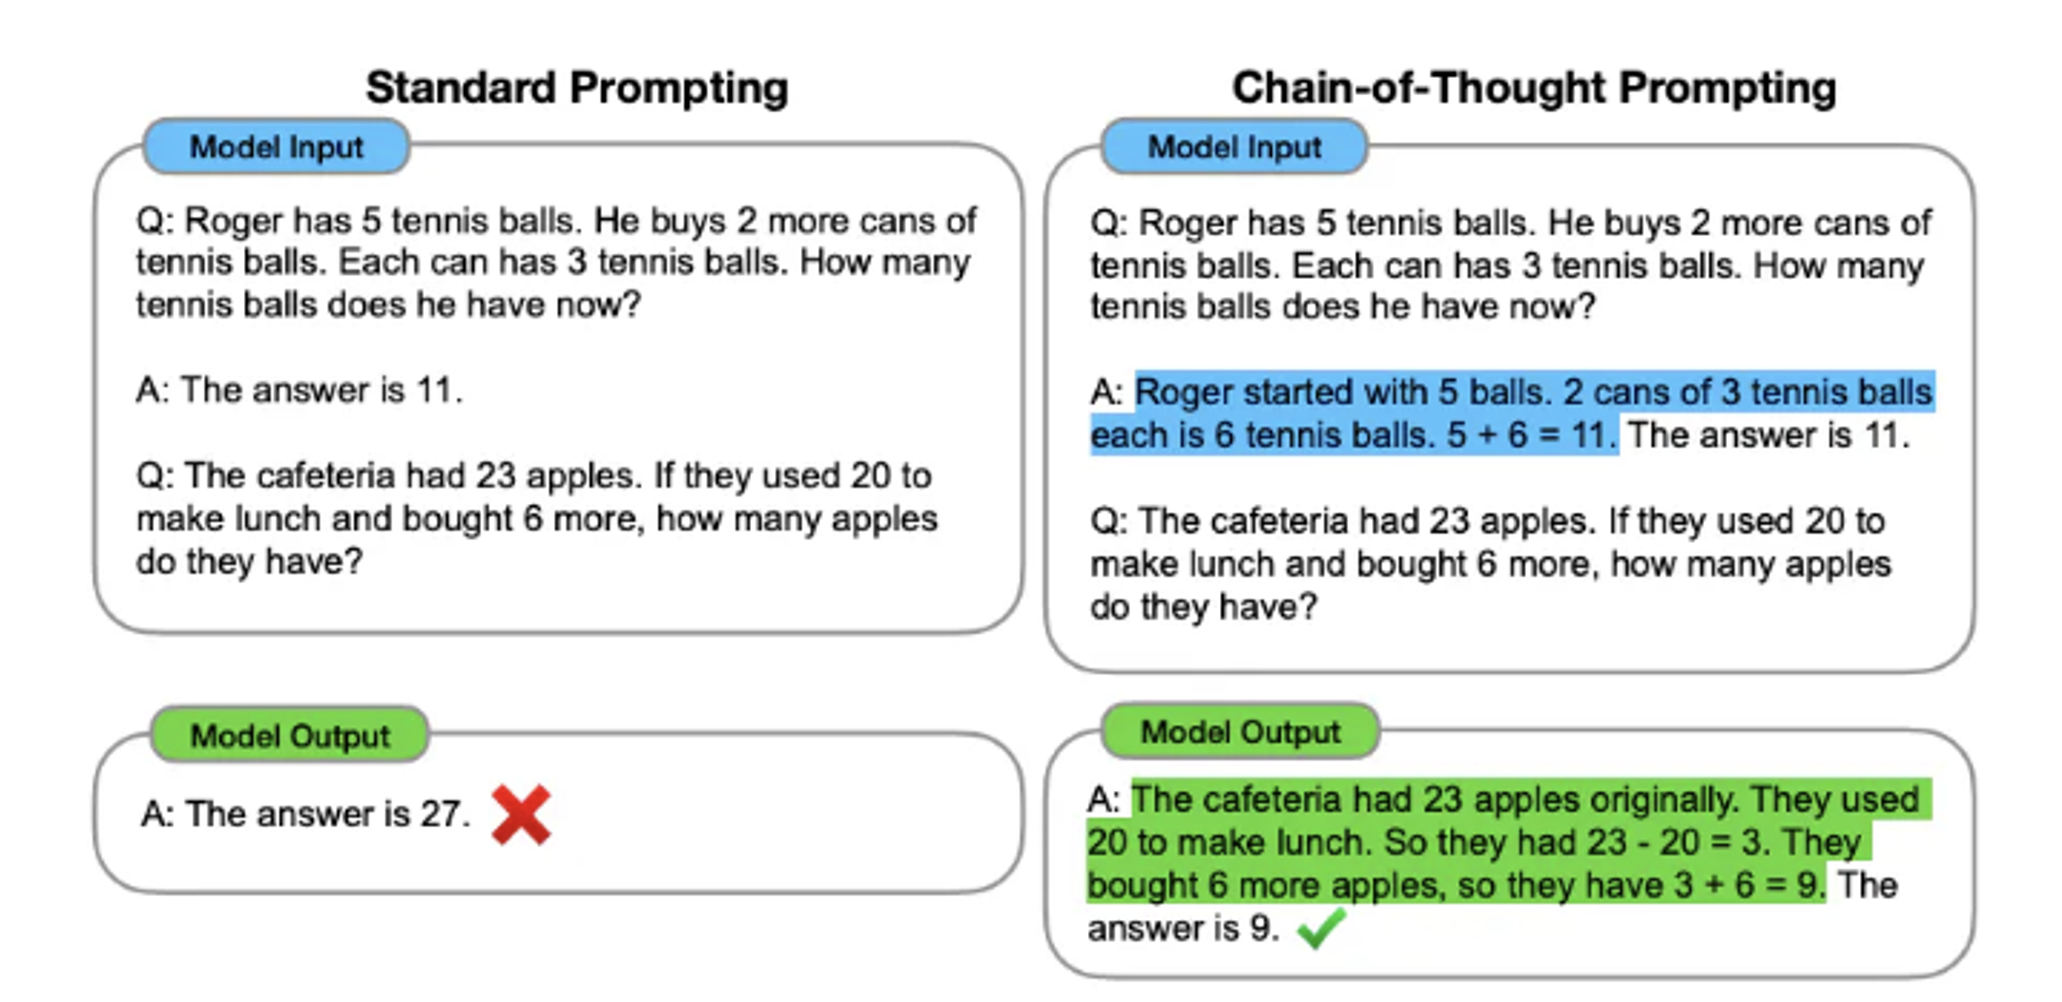
### Applications
It's used in scenarios requiring detailed explanation or logical deduction, such as mathematical problem-solving, detailed planning, or complex decision-making processes.
### Example 1: Scientific Reasoning
The difference between using a direct prompt and employing Chain of Thought (CoT) prompts, like the examples provided, lies in the structure and depth of reasoning that the model is guided to employ in generating its responses.

**Direct Prompt:** Typically asks for an answer or output directly related to the query without specifying the reasoning process. It might say, "What is photosynthesis in plants?"

**Chain of Thought Prompt:** Guides the model to break down the problem into a sequence of logical steps, leading to a solution. This Chain of Thought prompt guides the model through a structured exploration of photosynthesis. It's designed to elicit a response that:

**Begins with the initial step** of photosynthesis, focusing on how plants absorb sunlight. This sets the stage for a detailed exploration by starting with the very first action plants take in the photosynthesis process.

**Moves on to the chemical reactions involved**, diving deeper into the science behind photosynthesis. This middle step encourages the model to explain the complex interactions that convert light energy into chemical energy, providing a detailed look at the process.

**Concludes with the production of glucose**, tying the final output of photosynthesis back to the plant's nourishment and growth. This end step ensures that the explanation is comprehensive, covering the entire process from start to finish.

In [ ]:
# Prompt for explaining the process of photosynthesis in plants
photosynthesis_prompt = "Describe the process of photosynthesis in plants. Start by explaining how plants absorb sunlight, then detail the chemical reactions involved, and conclude with how glucose is produced."
photosynthesis_explanation = get_completion_falcon(photosynthesis_prompt)
print(photosynthesis_explanation)


invoking llm at Huggingface Hub
#### User: 
Describe the process of photosynthesis in plants. Start by explaining how plants absorb sunlight, then detail the chemical reactions involved, and conclude with how glucose is produced.

#### Response from falcon-7b-instruct:
Photosynthesis is the process by which plants, algae, and some bacteria convert sunlight, water, and carbon dioxide into glucose and oxygen. In the initial stage, the chlorophyll within plant cells absorbs sunlight, which provides the energy for the process. Sunlight is absorbed by chlorophyll molecules, which are found in the chloroplasts of plant cells.

The chemical reactions involved in photosynthesis are the absorption of light energy by chlorophyll, and the conversion of carbon dioxide and water into glucose


### Example 2: Decision Making in Business

In [ ]:
# Prompt for outlining steps for a company considering overseas expansion
business_decision_prompt = "A company is considering expanding its market overseas. Outline the steps it should take to evaluate this decision, starting with market research, analyzing competition, assessing legal requirements, and finally evaluating financial implications."
business_decision_steps = get_completion_falcon(business_decision_prompt)
print(business_decision_steps)

invoking llm at Huggingface Hub
#### User: 
A company is considering expanding its market overseas. Outline the steps it should take to evaluate this decision, starting with market research, analyzing competition, assessing legal requirements, and finally evaluating financial implications.

#### Response from falcon-7b-instruct:

1. Research the target market, including its size, purchasing power, and cultural norms.
2. Analyze the competitive landscape, including existing competitors and potential new ones.
3. Assess the legal environment, including regulations and laws that may affect the company's operations.
4. Evaluate the financial implications, such as currency exchange rates and taxes.
5. Develop a business plan that takes all of these factors into account and outlines strategies for success in the new market.


### Example 3: Mathematics Problem Solving


In [ ]:
# Prompt for solving an algebra problem with step-by-step explanation - how does the LLM perform?
math_problem_prompt = "Explain step-by-step how to solve the following algebra problem: If 2x + 3 = 10, what is the value of x?"
kwargs = {"max_length": 1200}
math_problem_solution = get_completion_falcon(math_problem_prompt, **kwargs)
print(math_problem_solution)

### 3.1: Few-Shot Chain-of-Thought (CoT) Prompting


In [ ]:
# Prompt for explaining the process of solving basic arithmetic problems
kwargs = {"max_length": 2200}
few_shot_COT_prompt =  """You are a mathematical genius.
The template of the question is given as Q: [question]. The template of the answer is given as A: [answer].
Help me solve the problem below using the examples given.

Examples:
Q: The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
A: The given numbers are: (4, 8, 9, 15, 12, 2, 1). Next select the odd numbers (9, 15, 1).  Adding all the selected odd numbers (9, 15, 1) gives 25. 25 is an odd number, hence the answer is False.

Q: The odd numbers in this group add up to an even number: 17, 10, 19, 4, 8, 12, 24.
A: The given numbers are: (17, 10, 19, 4, 8, 12, 24). Next select the odd numbers (17, 19).  Adding all the selected odd numbers (17, 19) gives 36. 36 is an even number, hence the answer is True.

Q: The odd numbers in this group add up to an even number: 16, 11, 14, 4, 8, 13, 24.
A: The given numbers are: (16, 11, 14, 4, 8, 13, 24). Next select the odd numbers (11, 13).  Adding all the selected odd numbers (11, 13) gives 24. 24 is an even number, hence the answer is True.

Q: The odd numbers in this group add up to an even number: 17, 9, 10, 12, 13, 4, 2.
A: The given numbers are: (17, 9, 10, 12, 13, 4, 2). Next select the odd numbers (17, 9, 13).  Adding all the selected odd numbers (17, 9, 13) gives 39. 39 is an odd number, hence the answer is False.

Problem:
Q: The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1.
A:
"""
#15 + 5 + 13 + 7 + 1 = 41
few_shot_COT_prompt_explanation = get_completion_falcon(few_shot_COT_prompt, **kwargs)
print(few_shot_COT_prompt_explanation)

### 4. Tree of Thought
Tree of Thought, a term less commonly used in the context of AI prompt engineering, can be interpreted as an approach that involves exploring multiple branches or paths of reasoning from a single starting point. This concept can be visualized like a tree, where each branch represents a different line of reasoning or a different aspect of a problem to explore. Unlike the linear progression in Chain of Thought, Tree of Thought allows for a more expansive exploration of possibilities, considering multiple outcomes or perspectives simultaneously.

### Applications
his approach could be particularly useful in brainstorming, where multiple potential solutions or ideas need to be explored, in creative writing for developing various plot lines, or in strategic planning where different scenarios are considered.

### Example 1: The Impact of Renewable Energy on Global Sustainability

**Scenario:** Evaluating the impact of renewable energy sources on global sustainability through the perspectives of technological innovation, policy development, and community engagement.

The response effectively demonstrates a **Tree of Thought (ToT)** approach by integrating diverse perspectives on renewable energy and sustainability. It combines insights from an engineer on **technological innovations**, a policy analyst on **regulatory impacts**, and a **community organizer** on grassroots movements. The synthesis of these perspectives emphasizes that global sustainability through renewable energy requires a multifaceted approach: technological advancements for efficiency and accessibility, supportive regulatory frameworks for promoting development and adoption, and active community organizing for widespread implementation. This example illustrates the ToT methodology's **strength in exploring and synthesizing multiple lines of inquiry, showcasing the complexity of addressing global challenges and the necessity of collaborative efforts across different sectors.**

In [ ]:
# Define the question/topic for the Tree of Thought
question = "Explore the impact of renewable energy on global sustainability."

# Construct a complex ToT prompt
tot_prompt = f'''Imagine three experts providing different perspectives on {question}:
1. An engineer focusing on technological innovations,
2. A policy analyst discussing regulatory impacts,
3. A community organizer highlighting grassroots movements.

Each expert presents their view, followed by a brief evaluation of the strengths and weaknesses of each perspective. Conclude with a synthesis of the most compelling elements from each to form a holistic answer.
'''
kwargs = {"max_length": 1000}
response = get_completion_falcon(tot_prompt, **kwargs)
print(response)


invoking llm at Huggingface Hub
#### User: 
Imagine three experts providing different perspectives on Explore the impact of renewable energy on global sustainability.:
1. An engineer focusing on technological innovations,
2. A policy analyst discussing regulatory impacts,
3. A community organizer highlighting grassroots movements.

Each expert presents their view, followed by a brief evaluation of the strengths and weaknesses of each perspective. Conclude with a synthesis of the most compelling elements from each to form a holistic answer.


#### Response from falcon-7b-instruct:

1. An engineer focusing on technological innovations: The use of renewable energy sources has the potential to reduce emissions and help combat climate change. Innovations in renewable energy technologies, such as solar and wind power, are allowing us to generate clean energy more efficiently and at a lower cost than traditional fossil fuels.

2. A policy analyst discussing regulatory impacts: Governments pla

### Example 2: Future of Work

**Scenario:** Exploring the future of work with a focus on remote work, automation, and workforce development.

In [ ]:
# Define the question/topic for the Future of Work
question_future_of_work = "Consider the future of work with a focus on remote work, automation, and workforce development."

# Construct a complex ToT prompt for the Future of Work
tot_prompt_future_of_work = f'''Imagine three experts providing different perspectives on {question_future_of_work}:
1. A technology futurist focusing on automation and artificial intelligence,
2. A human resources strategist concentrating on remote work and employee engagement,
3. A policy maker emphasizing workforce development and re-skilling programs.

Each expert presents their view, followed by a brief evaluation of the strengths and weaknesses of each perspective. Conclude with a synthesis of the most compelling elements from each to form a comprehensive outlook on how work will evolve in the next decade.
'''

kwargs={"max_length": 1000}
response_future_of_work = get_completion_falcon(tot_prompt_future_of_work, **kwargs)
print(response_future_of_work)


invoking llm at Huggingface Hub
#### User: 
Imagine three experts providing different perspectives on Consider the future of work with a focus on remote work, automation, and workforce development.:
1. A technology futurist focusing on automation and artificial intelligence,
2. A human resources strategist concentrating on remote work and employee engagement,
3. A policy maker emphasizing workforce development and re-skilling programs.

Each expert presents their view, followed by a brief evaluation of the strengths and weaknesses of each perspective. Conclude with a synthesis of the most compelling elements from each to form a comprehensive outlook on how work will evolve in the next decade.


#### Response from falcon-7b-instruct:

1. Technology Futurist: Automation and AI are becoming more prevalent and will continue to shape the future of work. Workforce development and upskilling will be necessary to keep up with the rapid pace of change. The future of work will be more remote and

### Example 3: Climate Change Mitigation Strategies

**Scenario:** Addressing climate change through technological innovation, lifestyle changes, and international cooperation.

In [ ]:
# Define the question/topic for Climate Change Mitigation Strategies
question_climate_change = "Address climate change through technological innovation, lifestyle changes, and international cooperation."

# Construct a complex ToT prompt for Climate Change Mitigation Strategies
tot_prompt_climate_change = f'''Imagine three experts analyzing climate change mitigation strategies:
1. An environmental scientist focused on technological solutions like carbon capture,
2. A social influencer advocating for sustainable lifestyle changes among individuals,
3. An international relations expert discussing the role of global treaties and cooperation.

After presenting their views on the effectiveness of their approaches, they critically assess each other’s strategies. Conclude with a unified strategy that incorporates elements from all three perspectives to combat climate change effectively.
'''

kwargs = {"max_length": 1000}
response_climate_change = get_completion_falcon(tot_prompt_climate_change, **kwargs)
print(response_climate_change)

invoking llm at Huggingface Hub
#### User: 
Imagine three experts analyzing climate change mitigation strategies:
1. An environmental scientist focused on technological solutions like carbon capture,
2. A social influencer advocating for sustainable lifestyle changes among individuals,
3. An international relations expert discussing the role of global treaties and cooperation.

After presenting their views on the effectiveness of their approaches, they critically assess each other’s strategies. Conclude with a unified strategy that incorporates elements from all three perspectives to combat climate change effectively.


#### Response from falcon-7b-instruct:

The three experts analyze climate change mitigation strategies by considering technological solutions, sustainable lifestyle changes, and global cooperation. They present their views on the effectiveness of their approaches and agree that a unified strategy should incorporate elements from all three perspectives.


## Conclusion

Throughout this tutorial, we've journeyed through the nuanced art of prompt engineering, uncovering the pivotal roles of clarity, relevance, specificity, and the strategic balance between detail and openness in crafting prompts for Large Language Models (LLMs) like Falcon 7B. By drawing parallels with designing scientific experiments, we've seen how precision in our queries can significantly influence the model's output, turning prompt engineering into a critical skill for harnessing the full potential of AI in a wide array of applications.

From the exploration of discrete and soft prompts to the advanced techniques of meta-prompts and iterative prompting, we've delved into how each approach can be tailored to suit specific goals—be it generating creative content, diving deep into complex topics, or engaging in dynamic problem-solving. The distinctions between Chain of Thought (CoT) and Tree of Thought (ToT) prompting further highlight the versatility and depth of engagement possible when interacting with AI, offering pathways to richer insights and more nuanced outputs.

##### Key Insights:

The effectiveness of a prompt is directly tied to its construction, with the best prompts being those that are clear, contextually rich, and appropriately detailed.
Advanced prompting techniques like meta-prompts and iterative prompting not only extend the capabilities of LLMs but also refine the interaction process, making AI a more powerful tool for exploration, learning, and creativity.
The exploration of CoT and ToT approaches underscores the importance of structured thought in achieving coherent and comprehensive responses from AI, illustrating the model's ability to engage with complex reasoning and creative narrative construction.
Looking Forward:

As we stand on the cusp of new advancements in AI, the field of prompt engineering offers endless possibilities for innovation. The techniques and principles discussed here serve as a foundation —a starting point for you to experiment, adapt, and discover new ways to communicate with and through AI. Whether your interest lies in content creation, education, research, or beyond, the skills developed through prompt engineering are invaluable assets in the digital age.

Happy prompting!

### Recommended Reading
- [Basic Prompt Engineering - Large Language Models (LLMs): Tutorial Workshop (Argonne National Laboratory)](https://github.com/argonne-lcf/llm-workshop/blob/main/tutorials/02-basic-prompt-engineering/Tutorial_02_Prompt_Engineering.ipynb)
- [LLM Prompt Engineering for Beginners: What It Is and How to Get Started](https://medium.com/thedeephub/llm-prompt-engineering-for-beginners-what-it-is-and-how-to-get-started-0c1b483d5d4f)
-[Prompt Engineering Guide](https://www.promptingguide.ai/techniques/knowledge)
- [Prompt Engineering for LLMs: The Art and Science of Building Large Language Model-Based Applications](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.oreilly.com/library/view/prompt-engineering-for/9781098156145/&ved=2ahUKEwj35OqfkKWJAxVJhIkEHSYNAiwQFnoECCwQAQ&usg=AOvVaw091NCqhKa-GArTW_MOSXJu)
-[Prompt Engineering for Arithmetic Reasoning Problems](https://towardsdatascience.com/prompt-engineering-for-arithmetic-reasoning-problems-28c8bcd5bf0e)
-[Prompt engineering: overview and guide](https://cloud.google.com/discover/what-is-prompt-engineering)

### Homework

1. Load in a generative model using the HuggingFace pipeline. Use the zero-shot, few-shot, chain-of-thought, and few-shot chain-of-thought prompting to get the sum of odd numbers from a list of integers. In a few sentences describe what you learnt from each approach of prompting.
- Next, play around with the temperature parameter. In a few sentences describe what you changes you notice.
